In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from rl_analysis.plotting import syllable_aliases, setup_plotting_env, savefig
from rl_analysis.util import rle, count_transitions
from rl_analysis.io.df import dlight_exclude
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [4]:
data_dirs = analysis_config["data_dirs"]
raw_dirs = analysis_config["raw_data"]
proc_dirs = analysis_config["intermediate_results"]
closed_loop_cfg = analysis_config["closed_loop_behavior"]
figure_cfg = analysis_config["figures"]
dlight_common_cfg = analysis_config["dlight_common"]

to generate all needed toml files

1. `use_photometry=True label_key=predicted_syllable`
2. `use_photometry=True, label_key=predicted_syllable (offline)`
3. `use_photometry=False label_key=predicted_syllable`


In [5]:
use_photometry = False
control_only = False
# label_key = "predicted_syllable (offline)"
label_key = "predicted_syllable"
highlight_targets = False
show_labels = False

In [6]:
if use_photometry and control_only:
    suffix = "photometry_control_"
elif control_only:
    suffix = "control_"
elif use_photometry:
    suffix = "photometry_"
else:
    suffix = ""

if "offline" in label_key:
    save_file = f"syllable_stats_{suffix}offline.toml"
else:
    save_file = f"syllable_stats_{suffix}online.toml"

if use_photometry:
    save_file = os.path.join(proc_dirs["dlight"], save_file)
else:
    save_file = os.path.join(proc_dirs["closed_loop_behavior"], save_file)

# Load in raw data and normalize

In [7]:
if use_photometry:
    rle_df = pd.read_parquet(
        os.path.join(raw_dirs["dlight"], "dlight_usages_offline_features.parquet")
    )
    rle_df = rle_df.loc[(rle_df["area"] == "dls")].copy()
    rle_df.loc[rle_df["mouse_id"].str.contains("chrimson"), "opsin"] = "chrimson"
    rle_df = dlight_exclude(
        rle_df, syllable_key="syllable", exclude_3s=False, exclude_target=False
    )
    rle_df = rle_df.loc[~rle_df["session_number"].isin([1, 2, 3, 4])].copy()
    rle_df["uniq_id"] = pd.factorize(
        list(zip(rle_df["uuid"], rle_df["session_number"]))
    )[0]

else:

    feedback_df = pd.read_parquet(
        os.path.join(raw_dirs["closed_loop_behavior"], "closed_loop_behavior.parquet"),
        filters=[
            ("experiment_type", "in", ["reinforcement"]),
            ("area", "in", ["snc (axon)", "ctrl"]),
        ],
    ).sort_index()
    if control_only:
        feedback_df = feedback_df.loc[
            (feedback_df["area"].isin(["ctrl"]))
            & (feedback_df["stim_duration"] == 0.25)
        ].copy()
    else:

        feedback_df = feedback_df.loc[
            (feedback_df["area"].isin(["snc (axon)", "ctrl"]))
            & (feedback_df["stim_duration"] == 0.25)
            & (feedback_df["opsin"].isin(["chr2", "ctrl"]))
            & (feedback_df["session_number"].isin([-1, 0]))
            & (feedback_df["syllable_group"] == 1)
        ].copy()


    feedback_df["syllable"] = feedback_df[label_key]

    rle_df = feedback_df.groupby("uniq_id")["syllable"].apply(rle)
    rle_df.index = rle_df.index.droplevel(0)
    rle_df = feedback_df.loc[rle_df.index]

# Make some graphs

In [8]:
usages = rle_df.groupby(["mouse_id", "uniq_id"])["syllable"].value_counts()

In [10]:
total_usages = usages.groupby("syllable").mean().sort_values()[::-1]
total_usages /= total_usages.sum()

In [11]:
per_mouse_usages = usages.groupby(["mouse_id", "syllable"]).mean().rename("usage")
per_mouse_average = per_mouse_usages.groupby("syllable").mean().sort_values()[::-1]
per_mouse_average.loc[-5] = 0
per_mouse_average /= per_mouse_average.sum()
mapping = {_: i for i, _ in enumerate(per_mouse_average.index)}
mapping_flip = {v: k for k, v in mapping.items()}

In [12]:
per_mouse_usages = per_mouse_usages.reset_index()
per_mouse_usages["syllable"] = per_mouse_usages["syllable"].map(mapping)

In [13]:
truncate = len(per_mouse_average.loc[per_mouse_average > 0.01])

In [14]:
durations = rle_df.groupby("uuid")["timestamp"].shift(-1) - rle_df["timestamp"]
duration_stats = durations.describe()

In [15]:
setup_plotting_env()

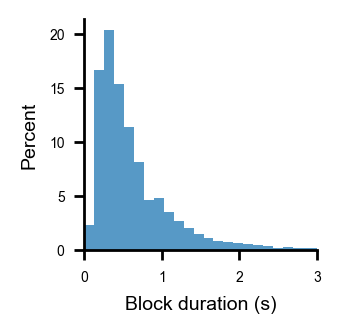

In [16]:
fig, ax = plt.subplots(1, figsize=(1.5, 1.5))
sns.histplot(
    durations,
    bins=np.linspace(0, 5, 40),
    stat="percent",
    # label="model-based",
    legend=False,
    element="step",
    ec=None,
    lw=0,
)
# plt.legend()
plt.xlabel("Block duration (s)")
plt.xlim(0, 3)
sns.despine()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"], f"moseq_{suffix}duration"
    ),
    bbox_inches="tight",
)

In [17]:
save_dct = {}
save_dct["syllable_to_sorted_idx"] = {str(k): v for k, v in mapping.items()}
save_dct["sorted_idx_to_syllable"] = {str(k): v for k, v in mapping_flip.items()}
save_dct["truncate"] = truncate
save_dct["usages"] = {str(k): v for k, v in per_mouse_average.to_dict().items()}
save_dct["duration"] = {}
save_dct["duration"]["mean"] = duration_stats.loc["mean"]
save_dct["duration"]["median"] = duration_stats.loc["50%"]
save_dct["duration"]["std"] = duration_stats.loc["std"]

In [18]:
with open(save_file, "w") as f:
    toml.dump(save_dct, f)

In [19]:
setup_plotting_env()

In [20]:
kwargs = {"scale": 0.5, "errwidth": 1, "join": False}

In [21]:
targets_sorted = [mapping[_] for _ in syllable_aliases.keys()]

In [22]:
per_mouse_usages["target"] = per_mouse_usages["syllable"].isin(targets_sorted)

In [23]:
if highlight_targets:
    kwargs["palette"] = ["b", "r"]
    kwargs["hue_order"] = [False, True]
    kwargs["hue"] = "target"
else:
    kwargs["palette"] = ["b"]

In [24]:
per_mouse_usages["usage_norm"] = per_mouse_usages.groupby("mouse_id")[
    "usage"
].transform(lambda x: x / x.sum())

In [25]:
setup_plotting_env()

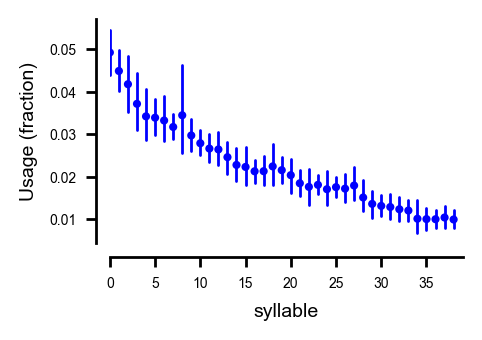

In [26]:
g = sns.catplot(
    data=per_mouse_usages.loc[per_mouse_usages["syllable"] < truncate],
    x="syllable",
    y="usage_norm",
    kind="point",
    legend=False,
    **kwargs,
)
if highlight_targets:
    for _target in targets_sorted:
        x = _target
        y = per_mouse_usages.groupby("syllable").mean(numeric_only=True).loc[_target]["usage_norm"]
        # plt.text(x + .5, y + .005, str(mapping_flip[_target]))
        plt.text(
            x + 0.5,
            y + 0.01,
            syllable_aliases[mapping_flip[_target]],
            rotation=45,
            fontsize=5,
        )

g.fig.set_size_inches(2, 1.25)
plt.ylabel("Usage (fraction)")
plt.xlim(0, save_dct["truncate"])
plt.xticks(np.arange(0, 37, 5))
# clean_ticks(g.axes.flat[0], "x", zero_symmetry=False, dtype=int)
sns.despine(offset=5)
# plt.xticks([])
# need to label with aliases if we're highlighting the target
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"], f"moseq_{suffix}usages_highlight-{highlight_targets}"
    ),
    bbox_inches="tight",
)

In [27]:
rle_df["syllable_sorted"] = rle_df["syllable"].map(mapping)

In [28]:
grand_tm = rle_df.groupby("uuid")["syllable_sorted"].apply(
    lambda x: count_transitions(x.dropna(), K=100)
)
grand_tm = np.sum(grand_tm)

In [29]:
trans = {}
trans["grand_ave"] = grand_tm[:truncate, :truncate]

In [30]:
from collections import defaultdict
import networkx as nx

g = defaultdict(list)
weights = defaultdict(list)
ebunch = defaultdict(list)
threshold = 0.1  # don't plot outgoing transition probabilities above this
eps = 0

for k, _trans in trans.items():

    _trans += eps
    _trans /= _trans.sum(axis=1, keepdims=True)

    r, c = np.where(_trans > threshold)
    degree = (_trans > threshold).sum(axis=1) + (_trans > threshold).sum(axis=0)
    outdegree = (_trans > threshold).sum(axis=1)
    indegree = (_trans > threshold).sum(axis=1)

    for _r, _c in zip(r, c):
        ebunch[k] += [(_r, _c, _trans[_r, _c])]
    g[k] = nx.MultiDiGraph()

    # add nodes in degree order
    g[k].add_nodes_from(np.argsort(outdegree)[::-1])
    g[k].add_weighted_edges_from(ebunch[k])
    weights[k] = np.array([_trans[u, v] for u, v in g[k].edges()])
    edge_list = list(g[k].edges(keys=True))

In [31]:
pos = nx.layout.circular_layout(list(g.values())[0])

In [32]:
compare_key = list(g.keys())[0]
# pos = nx.nx_agraph.graphviz_layout(list(g.values())[0], prog="circo")

In [33]:
if highlight_targets:
    node_colors = [
        "r" if mapping_flip[_] in syllable_aliases.keys() else "b" for _ in pos.keys()
    ]
    node_sizes = [
        55 if mapping_flip[_] in syllable_aliases.keys() else 20 for _ in pos.keys()
    ]
else:
    node_colors = "b"
    node_sizes = 5

In [34]:
setup_plotting_env()

In [35]:
weight_transform = lambda x: (x**3) * 25

# Can only run this after we get the joint map

In [36]:
joint_syllable_map = toml.load(
    os.path.join(proc_dirs["closed_loop_behavior"], "joint_syllable_map.toml")
)
joint_syllable_map = {int(k): v for k, v in joint_syllable_map.items()}

In [37]:
pos = {joint_syllable_map[mapping_flip[k]]: v for k, v in pos.items()}

KeyError: 35.0

In [ ]:
g["grand_ave"] = nx.relabel_nodes(g["grand_ave"], mapping_flip)
g["grand_ave"] = nx.relabel_nodes(g["grand_ave"], joint_syllable_map)

In [ ]:
node_sizes = 55
show_labels = True

In [ ]:
fig, ax = plt.subplots(1, len(g), figsize=(2.75, 2.75), sharex=True, sharey=True)
ax = [ax]
for _ax, (_k, _g) in zip(ax, g.items()):
    nx.draw(
        _g,
        pos,
        with_labels=show_labels,
        node_color="w",
        edge_color="k" if show_labels else None,
        width=np.maximum(weight_transform(weights[_k]), 0),
        node_size=node_sizes,
        font_size=5,
        ax=_ax,
        arrows=True,
        arrowsize=0.1,
        connectionstyle="arc3, rad=.2",
    )

    nx.draw_networkx_nodes(
        _g,
        pos,
        # node_color=node_colors,
        node_color="w" if show_labels else node_colors,
        edgecolors="k" if show_labels else None,
        node_size=node_sizes,
        ax=_ax,
    )

    _ax.axis("off")

# make a legend
ylimits = _ax.get_ylim()
xlimits = _ax.get_xlim()

# show levels
levels = [0.25, 0.5]

xedge = xlimits[1] * 0.9
xlen = xlimits[1] - xedge

ypos = ylimits[0] + (ylimits[1] - ylimits[0]) * 0.05
yinc = 0.2

for _level in levels:
    _ax.plot(
        [xedge, xedge + xlen],
        [ypos, ypos],
        lw=weight_transform(_level),
        clip_on=False,
        color="k",
    )
    ypos += yinc

plt.show()
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"moseq_{suffix}grand_ave_statemap_highlight-{highlight_targets}_nodelabels-{show_labels}",
    ),
    bbox_inches="tight",
    fmts=["png", "pdf"],
)

In [ ]:
joint_syllable_map[7]